In [ ]:
import os
import glob
import time
import numpy as np
import pandas as pd
import IPython.display as ipd
import librosa
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.style as ms
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.gridspec as gridspec
%matplotlib inline

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import load_model
import tensorflow as tf
from keras import backend as K
K.set_image_data_format('channels_first')
np.random.seed(7)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


DATA VISUALIZATION 

<class 'numpy.ndarray'> <class 'int'>
11
(20, 430)


(20, 97)

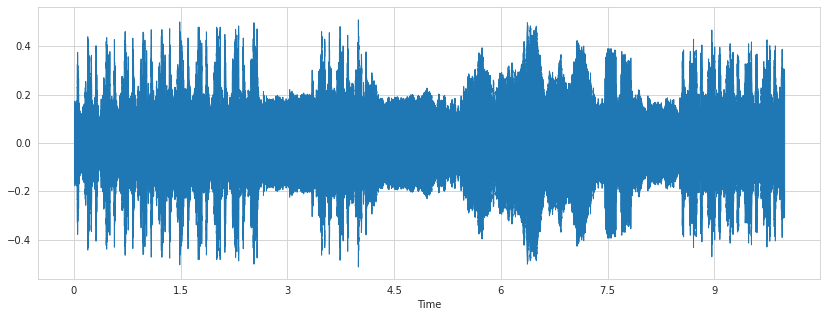

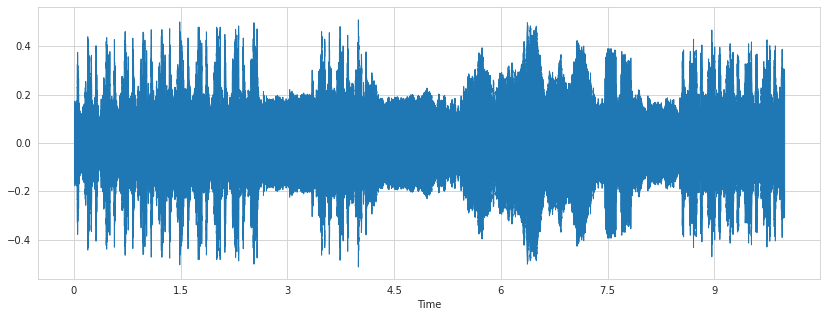

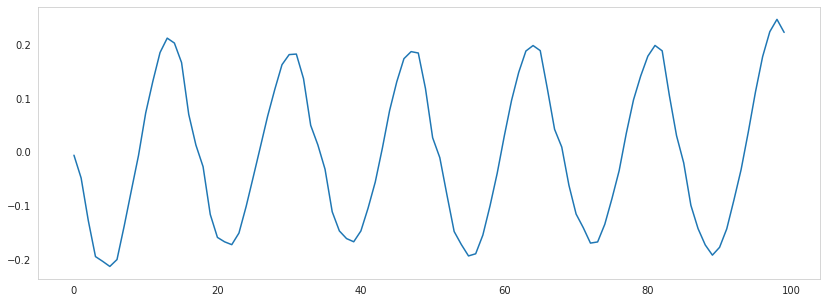

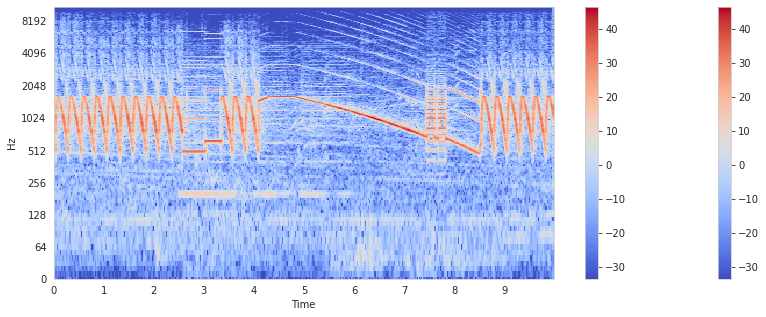

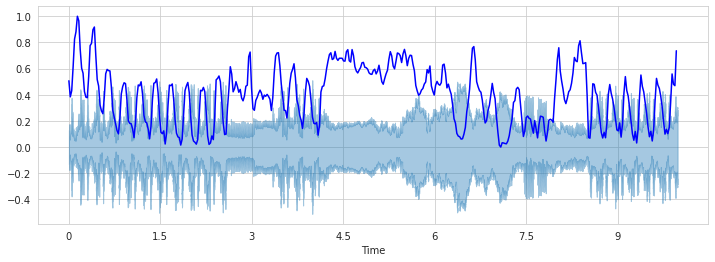

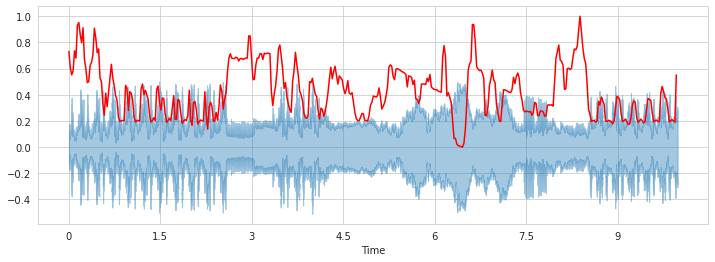

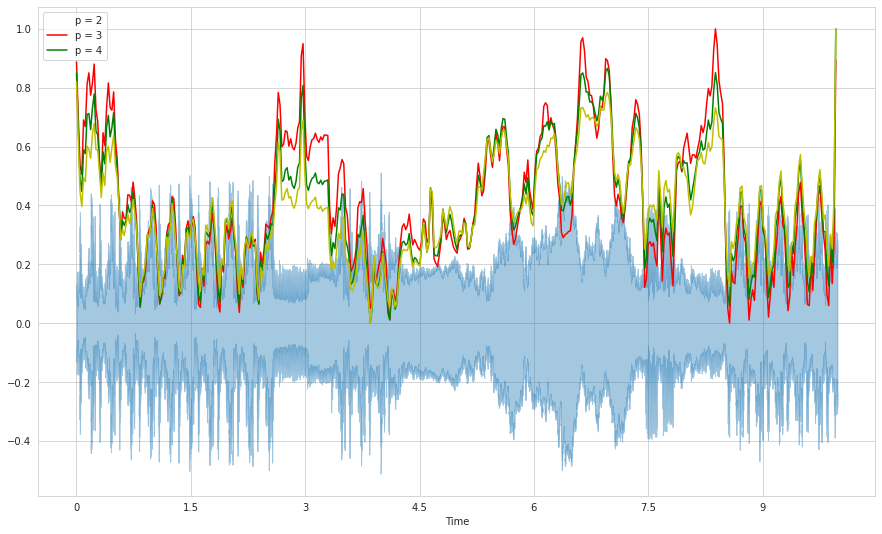

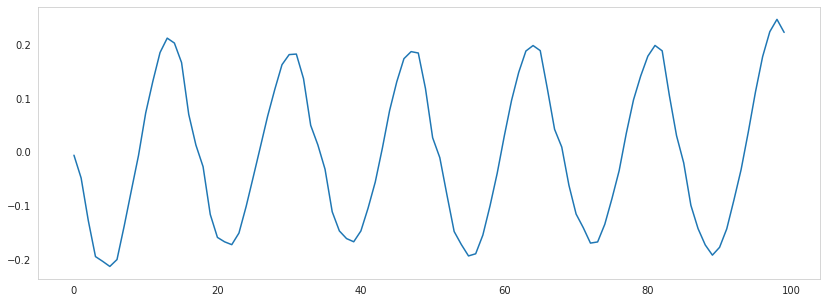

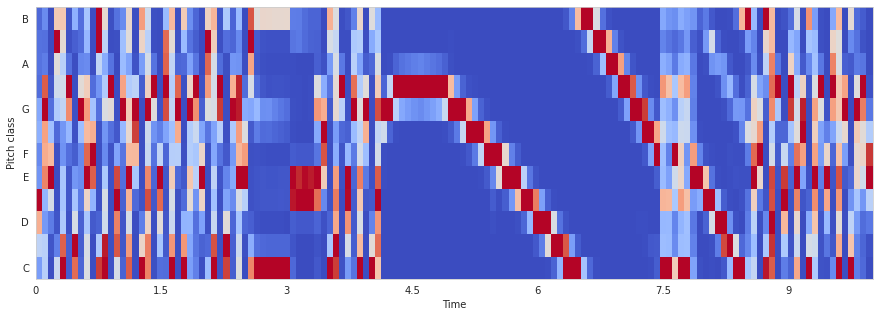

In [ ]:
audio_data = '/content/drive/MyDrive/cleaned_data/eval_balanced/Emergency/41.wav'
import IPython.display as ipd
ipd.Audio(audio_data)
x , sr = librosa.load(audio_data)
print(type(x), type(sr))
import IPython.display as ipd
ipd.Audio(audio_data)
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
(775,)
# Computing the time variable for visualization
plt.figure(figsize=(12, 4)) 
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
plt.figure(figsize=(12, 4))
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()
chromagram = librosa.feature.chroma_stft(x, sr=sr,hop_length=1600)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma',hop_length=1600, cmap='coolwarm')
mfccs = librosa.feature.mfcc(x, sr=44100)
print(mfccs.shape)
(20, 97)


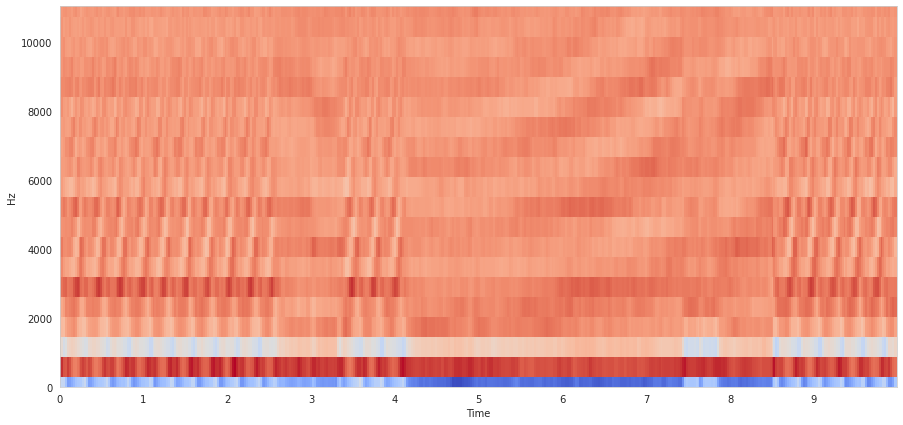

In [ ]:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time',y_axis='hz')

In [ ]:
def mfcc(y,sr=8000):
    return librosa.feature.mfcc(y=y,sr=sr, n_mfcc=12)

def extract_mfccs(y):
    mfccs_list = []
    ran = len(y)//160
    for i in range(ran-10):
        y_clip = y[160*i:160*(i+1)]
        mfccs_clip = mfcc(y_clip)
        mfccs_clip = np.array(mfccs_clip)
        mfccs_clip = mfccs_clip.flatten()
        mfccs_list.append(mfccs_clip)
    return mfccs_list

In [ ]:
# Read all the files from the dataset folder
path_em = '/content/drive/MyDrive/cleaned_data/train_balanced/Emergency'
path_nonem = '/content/drive/MyDrive/cleaned_data/train_balanced/nonEmergency'

em_files = glob.glob(os.path.join(path_em, '*.wav'))
nonem_files = glob.glob(os.path.join(path_nonem, '*.wav'))

In [ ]:
X_em = []
for fn in tqdm(em_files):
    y, sr = librosa.load(fn, sr=8000)
    features = extract_mfccs(y)
    X_em.extend(features)

  0%|          | 0/123 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=160
  n_fft, y.shape[-1]
100%|██████████| 123/123 [05:57<00:00,  2.91s/it]


In [ ]:
print(len(X_em))

51486


In [ ]:
count = 0
X_nonem = []
for fn in tqdm(nonem_files):
    y, sr = librosa.load(fn, sr=8000)
    if len(y) < 64000:
        continue
    else:
        features = extract_mfccs(y)
        X_nonem.extend(features)
        count += 1
        if count == 110:
            break

  7%|▋         | 109/1667 [06:52<1:38:20,  3.79s/it]


In [ ]:
print(len(X_nonem))

53756


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def prepare_data(X_em, X_nonem):
    X_em = np.array(X_em)
    X_nonem = np.array(X_nonem)
    
    X = np.vstack((X_em, X_nonem))
    Y = np.hstack((np.ones(len(X_em)), np.zeros(len(X_nonem))))
    
    scaler = StandardScaler()
    scaler.fit_transform(X)
    
    X, Y = shuffle(X, Y, random_state=7)  
    return X, Y, scaler

In [ ]:
X_train, Y_train, scaler1 = prepare_data(X_em, X_nonem)

In [ ]:
test_path_em = '/content/drive/MyDrive/cleaned_data/eval_balanced/Emergency'
test_path_nonem = '/content/drive/MyDrive/cleaned_data/eval_balanced/nonEmergency'

test_em_files = glob.glob(os.path.join(test_path_em, '*.wav'))
test_nonem_files = glob.glob(os.path.join(test_path_nonem, '*.wav'))

In [ ]:
X_test_em = []
for fn in tqdm(test_em_files):
    y, sr = librosa.load(fn, sr=8000)
    features = extract_mfccs(y)
    X_test_em.extend(features)

  0%|          | 0/134 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=160
  n_fft, y.shape[-1]
100%|██████████| 134/134 [05:57<00:00,  2.67s/it]


In [ ]:
import os
len(os.listdir( '/content/drive/MyDrive/cleaned_data/eval_balanced/Emergency'))

135

In [ ]:
import os
len(os.listdir( '/content/drive/MyDrive/cleaned_data/eval_balanced/nonEmergency'))

105

In [ ]:
import os
len(os.listdir( '/content/drive/MyDrive/cleaned_data/train_balanced/nonEmergency'))

1668

In [ ]:
import os
len(os.listdir( '/content/drive/MyDrive/cleaned_data/train_balanced/Emergency'))

123

In [ ]:
count = 0
X_test_nonem = []
for fn in tqdm(test_nonem_files):
    y, sr = librosa.load(fn, sr=8000)
    if len(y) < 64000:
        continue
    else:
        features = extract_mfccs(y)
        X_test_nonem.extend(features)

100%|██████████| 105/105 [05:31<00:00,  3.16s/it]


In [ ]:
X_test, Y_test, scaler2 = prepare_data(X_test_em, X_test_nonem)

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
model = Sequential()
###first layer
model.add(Dense(100,input_shape=(12,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1300      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto')
callbacks_list = [earlystop]

In [ ]:
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=512)
model.save("model_hi.h5")
print("Saved model to disk!")

Epoch 1/100
206/206 [==============================] - 5s 17ms/step - loss: 1.4063 - acc: 0.6847 - val_loss: 0.5903 - val_acc: 0.7006
Epoch 2/100
206/206 [==============================] - 3s 15ms/step - loss: 0.5230 - acc: 0.7651 - val_loss: 0.5521 - val_acc: 0.7135
Epoch 3/100
206/206 [==============================] - 3s 14ms/step - loss: 0.4769 - acc: 0.7925 - val_loss: 0.5342 - val_acc: 0.7254
Epoch 4/100
206/206 [==============================] - 3s 14ms/step - loss: 0.4551 - acc: 0.8059 - val_loss: 0.5255 - val_acc: 0.7345
Epoch 5/100
206/206 [==============================] - 3s 15ms/step - loss: 0.4387 - acc: 0.8169 - val_loss: 0.5149 - val_acc: 0.7411
Epoch 6/100
206/206 [==============================] - 3s 15ms/step - loss: 0.4264 - acc: 0.8224 - val_loss: 0.5100 - val_acc: 0.7492
Epoch 7/100
206/206 [==============================] - 3s 14ms/step - loss: 0.4144 - acc: 0.8284 - val_loss: 0.5115 - val_acc: 0.7509
Epoch 8/100
206/206 [==============================] - 3s 16ms

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.savefig('model_history.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


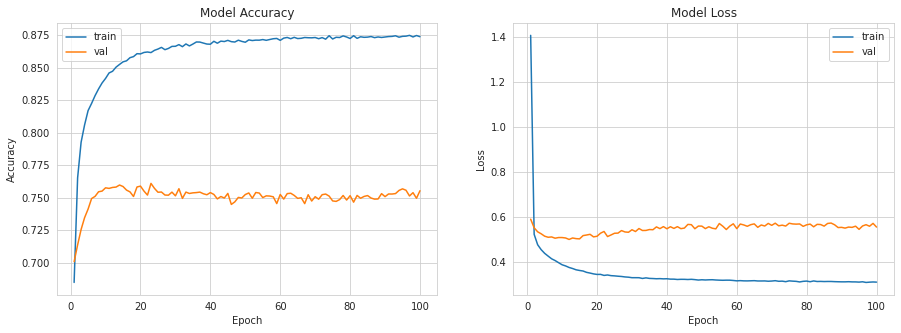

In [ ]:
plot_model_history(history)

3213/3213 [==============================] - 5s 2ms/step


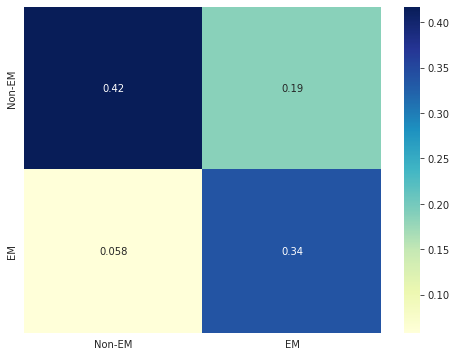

In [ ]:
Y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(Y_pred, Y_test)/max((Y_pred.size),(Y_test.size))
df_cm = pd.DataFrame(cm, index = ['Non-EM', 'EM'],
                  columns = ['Non-EM', 'EM'])
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True, cmap='YlGnBu')